In [1]:
pip install spotipy

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 138 kB 21.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=c0c5338d7b5a2498025590c1a3f99151aebb5a7e09d01830aafd0a22ee412dc6
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pwd

/content


In [5]:
%cd drive/My Drive/Colab Notebooks/Music Mood Recognition

/content/drive/My Drive/Colab Notebooks/Music Mood Recognition


In [6]:
!ls

1_Scraping.ipynb			    auth.py	 funcs.py
2_EDA					    data	 __pycache__
3_Modeling_with_preexisting_features.ipynb  EDA.py	 scrapes
4_feature_engineering.ipynb		    funcs.ipynb  Scraping.py


In [7]:
import os
import urllib
import librosa
import numpy as np
from funcs import *
import pandas as pd
import regex
from string import punctuation
from python_speech_features import mfcc, logfbank

In [8]:
song_df = pd.read_csv('./data/song_genres.csv')

In [9]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1244 non-null   object
 1   genre             1244 non-null   object
 2   track_name        1244 non-null   object
 3   location          1244 non-null   object
 4   preview_url       755 non-null    object
 5   filename          1244 non-null   object
 6   artist            1244 non-null   object
 7   danceability      1244 non-null   object
 8   energy            1244 non-null   object
 9   key               1244 non-null   object
 10  loudness          1244 non-null   object
 11  mode              1244 non-null   object
 12  speechiness       1244 non-null   object
 13  acousticness      1244 non-null   object
 14  instrumentalness  1244 non-null   object
 15  liveness          1244 non-null   object
 16  valence           1244 non-null   object
 17  tempo         

In [10]:
#We only want songs that have preview_url
song_df = song_df.copy()[song_df['preview_url'].notnull()]

In [11]:
# There are some residual headers left over from when we stored our csvs. Let's remove them.
song_df = song_df.copy()[song_df['track_name'] != 'track_name']

In [12]:
# The same song may have been in multiple playlists, so let's get rid of those
song_df.drop_duplicates(inplace=True)

In [13]:
song_df['track_name'].unique().shape[0]

168

In [14]:
mood_over_30 = song_df['mood'].value_counts() >= 30

In [15]:
song_df['mood'].value_counts()[mood_over_30]

Happy       195
Relaxing    162
Romance     154
Sad         142
Dark         98
Name: mood, dtype: int64

In [16]:
mood_list = [
    'Romance',
    'Happy',
    'Sad',
    'Dark',
    'Relaxing'
]

In [17]:
song_df_5_moods = song_df[song_df['mood'].isin(mood_list)]

In [18]:
song_df_5_moods.drop_duplicates(subset=['id'])['mood'].value_counts()

Happy       56
Dark        33
Relaxing    28
Romance     27
Sad         25
Name: mood, dtype: int64

In [19]:
size = 30        # sample size
np.random.seed(182)
pick_samples = lambda x: x.sample(size, replace=True) # without replacement by default

# Thanks Zero from stack overflow for this: https://stackoverflow.com/questions/22472213/python-random-selection-per-group
songs_sampled_30 = song_df_5_moods.groupby('mood', as_index=False).apply(pick_samples).reset_index(drop=True)

In [20]:
# Let's save this to a .csv
songs_sampled_30.to_csv('./data/five_moods_30_samp.csv', index=False)

In [21]:
# We should have 5000 of each song
songs_sampled_30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                150 non-null    object
 1   genre             150 non-null    object
 2   track_name        150 non-null    object
 3   location          150 non-null    object
 4   preview_url       150 non-null    object
 5   filename          150 non-null    object
 6   artist            150 non-null    object
 7   danceability      150 non-null    object
 8   energy            150 non-null    object
 9   key               150 non-null    object
 10  loudness          150 non-null    object
 11  mode              150 non-null    object
 12  speechiness       150 non-null    object
 13  acousticness      150 non-null    object
 14  instrumentalness  150 non-null    object
 15  liveness          150 non-null    object
 16  valence           150 non-null    object
 17  tempo           

In [22]:
# Do we have 30 of each song?
songs_sampled_30['mood'].value_counts()

Happy       30
Dark        30
Relaxing    30
Romance     30
Sad         30
Name: mood, dtype: int64

In [23]:
moods = list(songs_sampled_30['mood'].unique())

In [24]:
# # Uncomment to save new folders
# # Now let's get the 30-second song sample into something we can use
for i in range(songs_sampled_30.shape[0]):
  # We need to get the preview url, mood, and track name for file naming
  url = songs_sampled_30.loc[i, "preview_url"]
  mood = songs_sampled_30.loc[i, "mood"]
  track_name = songs_sampled_30.loc[i, "track_name"]

  # People put a lot of symbols in their songs (esp. classical music), so we need to clean those
  track_name = ' '.join(regex.findall('[A-Za-z0-9]+', track_name))
          
  # Let's open the mp3 file and make folders
  mp3file = urllib.request.urlopen(url)
  os.makedirs(f'./scrapes/{mood}', exist_ok=True)

  # Let's write this song to a folder! Adding z-filled numbers to counter songs with the same title being overwritten
  with open(f'./scrapes/{mood}/{str(i).zfill(4)}_{track_name.strip(punctuation)}.mp3','wb') as output:
    output.write(mp3file.read())


In [25]:
# Got this idea from https://www.youtube.com/watch?v=Z7YM-HAz-IY&list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P
signals = {}
fft = {}
fbank = {}
mfccs = {}

for g in moods:
    g_df = songs_sampled_30[songs_sampled_30['mood'] == g].head(2) # Create a dataframe for the class
    for i in range(2):
        track_name = g_df.loc[g_df.index[i], "track_name"]
        track_name = ' '.join(regex.findall('[A-Za-z0-9]+', track_name))
        signal, rate = librosa.load(f'./scrapes/{g}/{str(g_df.index[i]).zfill(4)}_{track_name.strip(punctuation)}.mp3') # Get the signal and rate from each file
        mask = envelope(signal, rate, 0.0005)
        signal = signal[mask] # Cutting out the silences at the beginning and end (if any)
        signals[f'{g}_{i + 1}'] = signal
        fft[f'{g}_{i + 1}'] = calc_fft(signal, rate)
        bank = logfbank(signal[:rate], 
                        rate, 
                        nfilt=26, 
                        nfft=1103).T
        fbank[f'{g}_{i + 1}'] = bank
        mfccs[f'{g}_{i + 1}'] = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=round(int(44100) / 40)).T
        print(f'Finished with folder {g}_{i + 1}, moving on!')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Dark_1, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Dark_2, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Happy_1, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Happy_2, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Relaxing_1, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Relaxing_2, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Romance_1, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Romance_2, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Sad_1, moving on!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder Sad_2, moving on!


FileNotFoundError: ignored

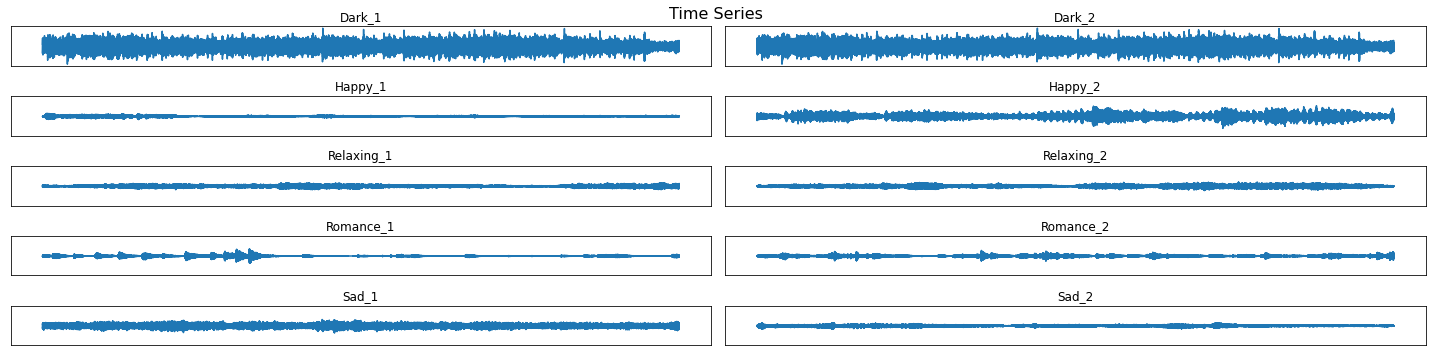

In [26]:
plot_signals(signals)
plt.savefig('./images/time_series_10g.png', dpi=100);

In [ ]:
plot_mfccs(mfccs, signals)
plt.savefig('./images/mfcc_10g.png', dpi=100);